# Benchmarking spike sorters


To benchmark the spike sorting algorithms, one of the easiest option is to design artifical dataset, in order to know exactly what is created, and to have a proper "ground truth" to compare with. 

To do so, MEArec is a python package that can help you to generate such artificial datasets. Basically, given some templates and a probe layout, the software will generate traces that can later be used for benchmarking the sorting algorithms. In this notebook, we'll try to get a quick overview of the features allowed by MEArec such that you can test the limits of various spike sorters. 

The comparison between different sorters can be tedious, since every one of them has a different file format. However, spikeinterface can act as a universal wrapper allowing you to launch and read the results of the sorters. Moreover, spikeinterface comes with numerous analysis functions that will allow you to quickly assess the quality of a spike sorting, and compute quality metrics with respect to the Ground Truth that have been generated


The only file needed here will be "templates_Neuronexus-32_100.h5", that we will use to generate the artificial recordings.

In [2]:
%matplotlib widget

In [3]:
from pathlib import Path
import os

import numpy as np
import matplotlib.pyplot as plt

import MEArec as mr

import neo
import quantities as pq

import spikeinterface.full as si

## Step 1 : generation of the recordings

Here is a small code that will generate a recording given an already generated "templates" file.



In [4]:
basedir = Path('.')
template_filename = basedir / 'templates_Neuronexus-32_100.h5'


duration = 30*60 # duration (in s) of the recording
n_cell = 10 # number of cells we want to create
probe = 'Neuronexus-32' # probe layout
recording_filename = basedir / f'recordings_collision_{n_cell}cells_{probe}_{duration:0.0f}s.h5'

In [5]:
# some parameters should be provided
fs = 30000. # sampling rate (in Hz)
spikerate = 5. # firing rate of the cells (in Hz)


First, we need to generate the spike trains that we want to inject into our traces. The easiest thing is to generate Poisson spike trains

In [7]:
# generate poisson spiketrains, for every cell in our recording
spiketimes = []
for i in range(n_cell):
    n = int(spikerate * duration)
    stimes = np.random.rand(n) * duration
    stimes = np.sort(stimes)
    spiketimes.append(stimes)

# make neo spiketrains
spiketrains = []
for i in range(n_cell):
    spiketrain = neo.SpikeTrain(spiketimes[i], units='s', t_start=0*pq.s, t_stop=duration*pq.s)
    spiketrain.annotate(cell_type='E')
    spiketrains.append(spiketrain)

Now we need to use MEARec to generate an artificial recording, given our pre-generated templates and our spike trains. The amount of noise in the recording can be controlled via the parameter noise_level

In [9]:
# generate signals from spiketrain
spgen = mr.SpikeTrainGenerator(spiketrains=spiketrains)

rec_params = mr.get_default_recordings_params()
rec_params['recordings']['fs'] = fs
rec_params['recordings']['sync_rate'] = None
rec_params['recordings']['sync_jitter'] = 5
rec_params['recordings']['noise_level'] = 5
rec_params['recordings']['filter'] = False
rec_params['recordings']['chunk_duration'] = 10.
rec_params['spiketrains']['duration'] = duration
rec_params['spiketrains']['n_exc'] = n_cell
rec_params['spiketrains']['n_inh'] = 0
rec_params['templates']['n_overlap_pairs'] = None
rec_params['templates']['min_dist'] = 0

recgen = mr.gen_recordings(params=rec_params, spgen=spgen, 
            templates=template_filename, verbose=True,
            n_jobs=1, tmp_mode='memmap')



Noise Level  5
Templates selection seed:  9416
Selecting cells
Padding template edges
Elapsed pad time: 0.12686872482299805
Elapsed resample time: 0.007382869720458984
Creating time jittering
Elapsed jitter time: 0.248337984085083
Computing spike train SNR
Adding spiketrain annotations
Convolution seed:  9857
Electrode modulaton
Adding noise
Noise seed:  6537
Elapsed time:  126.14232109999284


In [10]:
# Then we can save our recording
mr.save_recording_generator(recgen, filename=recording_filename)

## Step 2 : opening and ploting the signals and the spikes from our ground truth

In [11]:
# We create a mearec object
mearec_object = mr.load_recordings(recording_filename)

# And use it to load the recording
rec  = si.MEArecRecordingExtractor(recording_filename)

# and the ground truth sorting
sorting_gt = si.MEArecSortingExtractor(recording_filename)


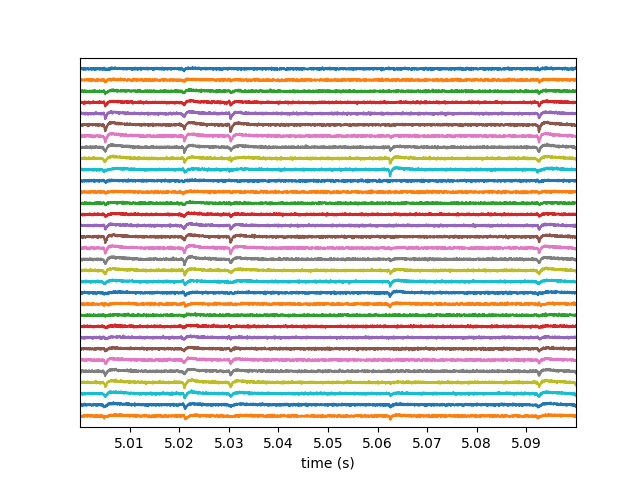

In [12]:
si.plot_timeseries(rec, time_range=(5,5.1))

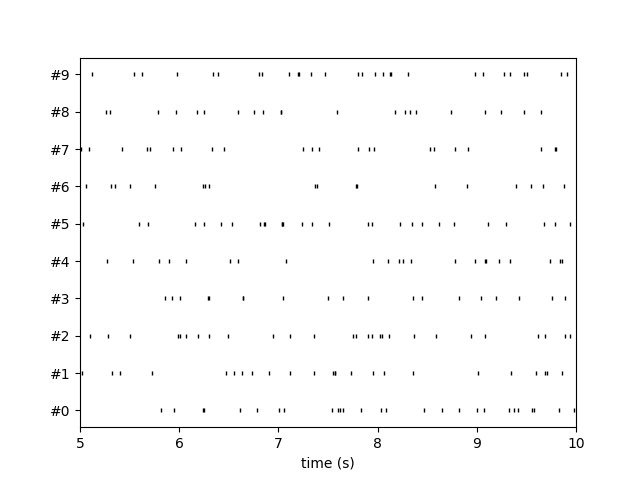

In [15]:
# We can also look at spikes
si.plot_rasters(sorting_gt, time_range=(5,10))

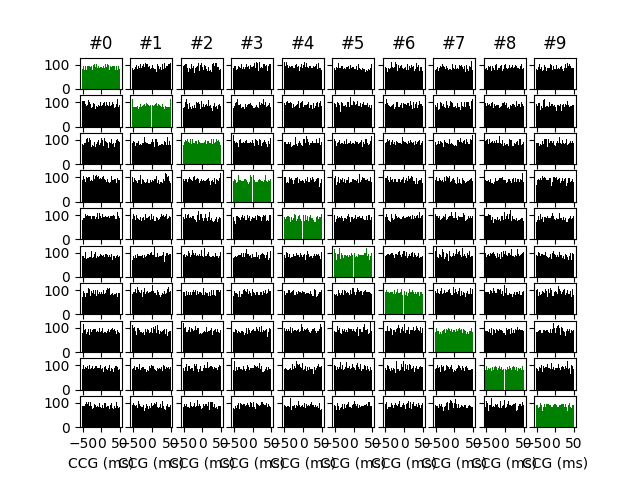

In [16]:
#Or even at thecross correlograms between the injected neurons (should be flat, because Poisson sources)
si.plot_crosscorrelograms(sorting_gt, bin_ms=2, window_ms=100, symmetrize=True)

### step 3 : run several sorters on this

### step 4 : run comparison and plot agreement matrix

### step 5 use study object and plot performences